In [14]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from copy import deepcopy
from feature_extraction import *
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from train_models import get_model_scores
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
warnings.filterwarnings('ignore')

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/clean_skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/clean_language.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/clean_education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6
    study_size = 55
    school_size = 50
    language_size = 8
    degree_size = 18
    skill_size = 120
    skill_exact_match =  False
    degree_exact_match =  True
    school_exact_match =  True
    study_exact_match =  False

In [15]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)

df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [16]:
def fix_location(dataframe: pd.DataFrame, feature: str = 'location') -> pd.DataFrame:

    tr_cities = load_tr_cities()
    df_ = dataframe.copy()
    df_.loc[df_[feature].astype(str).str.contains('Kahraman Maras'), feature] = 'Kahramanmaras, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Şanliurfa'), feature] = 'Sanliurfa, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('İçel'), feature] = 'Mersin, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Afyon'), feature] = 'Afyonkarahisar, Turkey'
    df_[feature] = df_[feature].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_[feature] = df_[feature].apply(lambda x: x.upper().strip())
    df_[feature] = df_[feature].apply(lambda x: translation(str(x)))
    for city in tr_cities:
        df_[feature] = df_[feature].apply(lambda x: city if city in x else x)
    df_[f'{feature}_based_on_tr'] = df_[feature].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)
        
    return df_

skills_df = load_skills(config.skills_path, config.skill_size, exact_match=config.skill_exact_match)
school_df = load_school(config.education_path, config.school_size, exact_match = config.school_exact_match)
degree_df = load_degree(config.education_path, config.degree_size, exact_match = config.degree_exact_match)
study_df = load_study(config.education_path, config.study_size, exact_match = config.study_exact_match)
lang_df = load_languages(config.languages_path, config.language_size)
exp_df = load_work_experiences(config.exp_path)

df = fix_location(df)
df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(school_df, on = ['user_id'], how = 'left')
df = df.merge(degree_df, on = ['user_id'], how = 'left')
df = df.merge(study_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')
df = add_populations(df)
#df = add_employment(df)

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')
df['active_employees_by_companies'] = df.groupby(by = 'company_id')['user_id'].transform('nunique')
#df['nunique_industries_by_companies'] = df.groupby(by = 'company_id')['industry'].transform('nunique')

#df['active_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')
#df['nunique_locations_by_industries'] = df.groupby(by = 'industry')['location'].transform('nunique')

#train_df = df.loc[df['moved_after_2019'].notnull()]
#test_df = df.loc[df['moved_after_2019'].isnull()]
#train_df, test_df = label_encode(["company_id", 'location'], train_df, test_df, fillna=True)
#df = train_df.append(test_df).reset_index(drop = True)

print(df.shape)
df.head()

100%|██████████| 18/18 [00:00<00:00, 31.78it/s]


(66274, 291)


,user_id,industry,location,moved_after_2019,location_based_on_tr,skill_.net,skill_administration,skill_agile,skill_agile methodologies,skill_ajax,...,company_skew_days_to_quit,company_nunique_employees,company_lifetime,company_last_hire,avg_days_to_quit_diff,avg_days_to_quit_ratio,company_hire_ratio,population,nunique_company_by_industries,active_employees_by_companies
0,1301,Information Technology and Services,ISTANBUL,1.0,1,0.0,0.0,1.0,1.0,0.0,...,1.817045,1410.0,11902.0,31.0,465.280537,2.040896,8.441135,15907951.0,3285.0,665.0
1,6950,Internet,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,1.387537,66.0,1887.0,61.0,-131.480769,0.749680,28.590909,15907951.0,744.0,53.0
2,4880,Online Media,TURKEY,0.0,1,0.0,0.0,0.0,0.0,1.0,...,NaN,4.0,610.0,610.0,NaN,NaN,152.500000,NaN,32.0,4.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,1.817045,1410.0,11902.0,31.0,-2496.719463,0.267609,8.441135,15907951.0,680.0,665.0
4,11005,Banking,ISTANBUL,0.0,1,1.0,0.0,0.0,0.0,0.0,...,1.304231,678.0,5235.0,31.0,-299.166667,0.736726,7.721239,15907951.0,429.0,402.0


In [17]:
#df.loc[df['industry'] == '-1', 'industry'] = np.nan
#
#def fill_industry_with_skills(dataframe: pd.DataFrame, skills_dataframe: pd.DataFrame) -> pd.DataFrame:
#
#    df_ = dataframe.copy()
#    skills_df_ = skills_dataframe.copy()
#
#    non_missing_df = df_.loc[df_["industry"].notnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])
#
#    search_df = df_.loc[df_["industry"].isnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])[
#        non_missing_df.columns
#    ]
#    
#    match_results = dict()
#    for idx, row in search_df.iterrows():
#        employee = row['user_id']
#        missing_data_point = [row[col] for col in search_df.columns if col not in ['user_id', 'industry']]
#        manhattan_dist = np.abs(non_missing_df.drop(columns = ['user_id', 'industry'], axis = 1) - missing_data_point).sum(axis=1)
#        match_df = non_missing_df.assign(dist=manhattan_dist).copy()
#
#        if manhattan_dist.min() < 3:
#            i = 1
#            while i < 20:
#                avg_dist = match_df.sort_values("dist")[:i]["dist"].mean()
#                if avg_dist > 4.25:
#                    break
#                match_industry = match_df.sort_values("dist")[:i]["industry"].mode().values[0]
#                i += 1
#            match_results[employee] = match_industry
#        else:
#            match_industry = match_df.sort_values("dist")["industry"].values[0]
#            match_results[employee] = match_industry
#            continue
#        
#        del match_df
#        gc.collect()
#
#    print(f'industry matches: {len(match_results)}')
#    for key in match_results.keys():
#        df_.loc[df_['user_id'] == key, 'industry'] = match_results[key]
#
#    return df_
#
#print(f"industry missing values: {df['industry'].isnull().sum()}")
#df = fill_industry_with_skills(df, skills_df)
#df['industry'] = df['industry'].fillna('Computer Software')
#df['location'] = df['location'].fillna('ISTANBUL')
#print(f"industry missing values: {df['industry'].isnull().sum()}")
#df.head()

In [18]:
check_missing(df)[:20]

,feature,n_missing,missing_ratio
265,employee_std_days_to_quit,43234,0.652352
281,company_skew_days_to_quit,29310,0.442255
266,employee_med_days_to_quit,29249,0.441334
262,employee_last_days_to_quit,29249,0.441334
263,employee_min_days_to_quit,29249,0.441334
264,employee_max_days_to_quit,29249,0.441334
126,language_arabic,28984,0.437336
134,total_languages,28984,0.437336
133,language_turkish,28984,0.437336
131,language_russian,28984,0.437336


In [19]:
#df[['total_degrees', target]].corr()

In [20]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id',
                'employee_last_experience_year',
                'employee_last_experience_month',
                #'employee_last_location',
                #'company_2th_id', 'company_3th_id'
                'employee_first_experience_year',
                #'employee_first_experience_month'
                ]
drop_features = ['user_id']

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 290)
test_set: (13255, 290)


In [21]:
cat1 = CatBoostClassifier(
    **{
        "one_hot_max_size": 150,
        "depth": 12,
        "learning_rate": 0.02,
        "boosting_type": "Plain",
        "bootstrap_type": "MVS",
        "iterations": 4000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

cat2 = CatBoostClassifier(
    **{
        "one_hot_max_size": 138,
        "depth": 11,
        'learning_rate': 0.0175,
        "boosting_type": "Plain",
        "bootstrap_type": "Bernoulli",
        'subsample': 0.81,
        "iterations": 5000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

xgb1 = XGBClassifier(
    **{
        "max_depth": 12,
        "subsample": 0.84,
        "learning_rate": 0.012,
        "enable_categorical": True,
        "random_state": config.seed,
        "tree_method": "hist",
        "n_estimators": 5000,
    }
)

xgb2 = XGBClassifier(
    **{
        "max_depth": 11,
        "learning_rate": 0.015238768735012887,
        "subsample": 0.8023883794058948,
        "tree_method": "hist",
        "enable_categorical": True,
        "random_state": config.seed,
        "n_estimators": 5000,
        "objective": "binary:logistic",
    }
)

skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)


-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 289)
val: (8837, 289)
[0]	validation_0-logloss:0.69071
[250]	validation_0-logloss:0.53617
[500]	validation_0-logloss:0.50541
[750]	validation_0-logloss:0.48425
[1000]	validation_0-logloss:0.46972
[1250]	validation_0-logloss:0.45991
[1500]	validation_0-logloss:0.45264
[1750]	validation_0-logloss:0.44804
[2000]	validation_0-logloss:0.44526
[2250]	validation_0-logloss:0.44407
[2500]	validation_0-logloss:0.44380
[2750]	validation_0-logloss:0.44466
[2964]	validation_0-logloss:0.44547


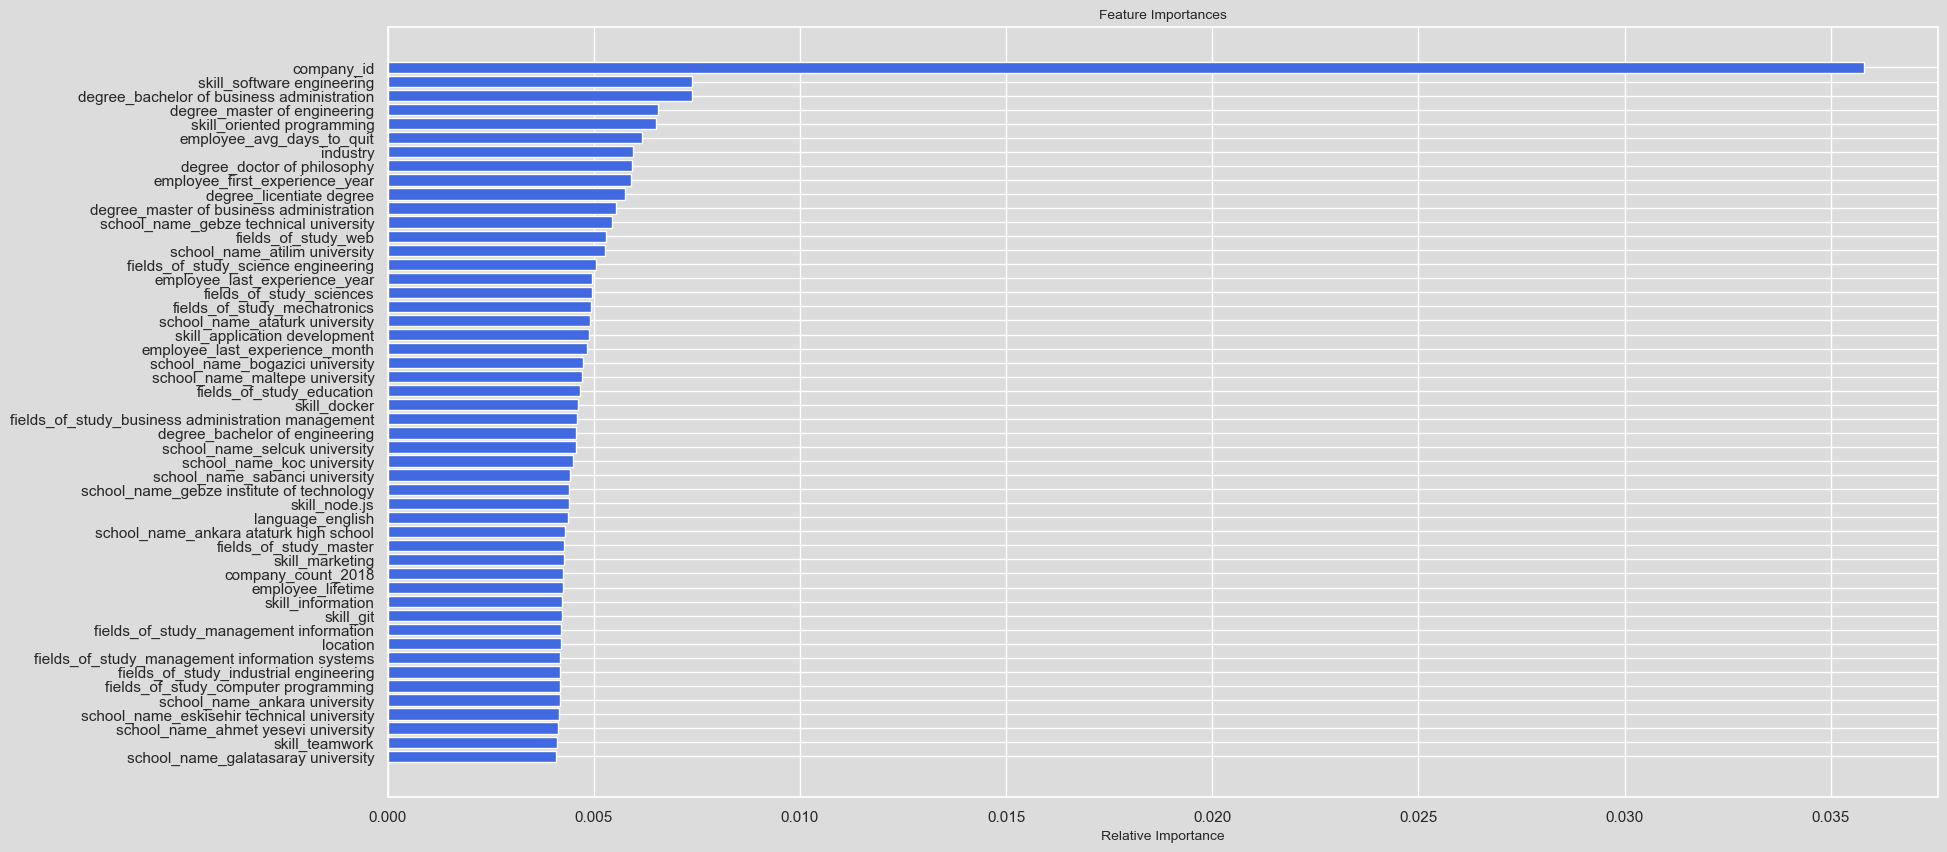

fold accuracy: 0.7861265135226887
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 289)
val: (8837, 289)
[0]	validation_0-logloss:0.69074
[250]	validation_0-logloss:0.53670
[500]	validation_0-logloss:0.50621
[750]	validation_0-logloss:0.48615
[1000]	validation_0-logloss:0.47058
[1250]	validation_0-logloss:0.46003
[1500]	validation_0-logloss:0.45199
[1750]	validation_0-logloss:0.44685
[2000]	validation_0-logloss:0.44355
[2250]	validation_0-logloss:0.44187
[2500]	validation_0-logloss:0.44168
[2750]	validation_0-logloss:0.44218
[2933]	validation_0-logloss:0.44267


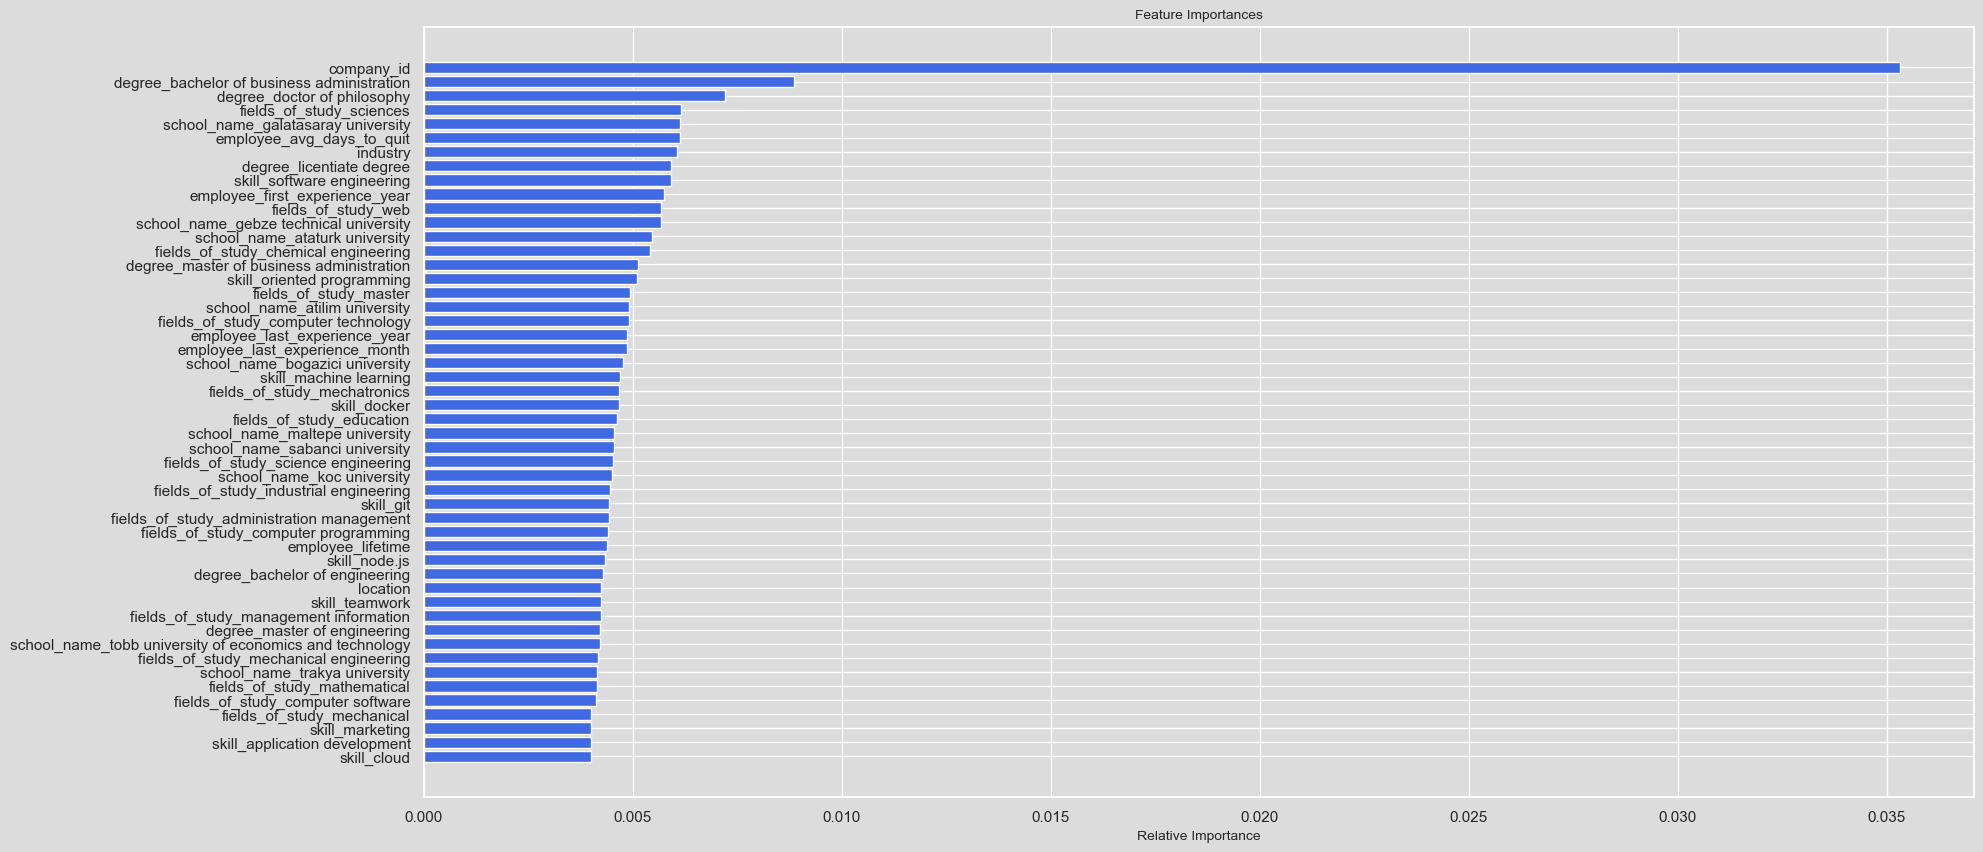

fold accuracy: 0.7843159443249972
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 289)
val: (8837, 289)
[0]	validation_0-logloss:0.69059
[250]	validation_0-logloss:0.53489
[500]	validation_0-logloss:0.50384
[750]	validation_0-logloss:0.48362
[1000]	validation_0-logloss:0.46898
[1250]	validation_0-logloss:0.45841
[1500]	validation_0-logloss:0.45141
[1750]	validation_0-logloss:0.44683
[2000]	validation_0-logloss:0.44400
[2250]	validation_0-logloss:0.44237
[2500]	validation_0-logloss:0.44206
[2750]	validation_0-logloss:0.44240
[2934]	validation_0-logloss:0.44305


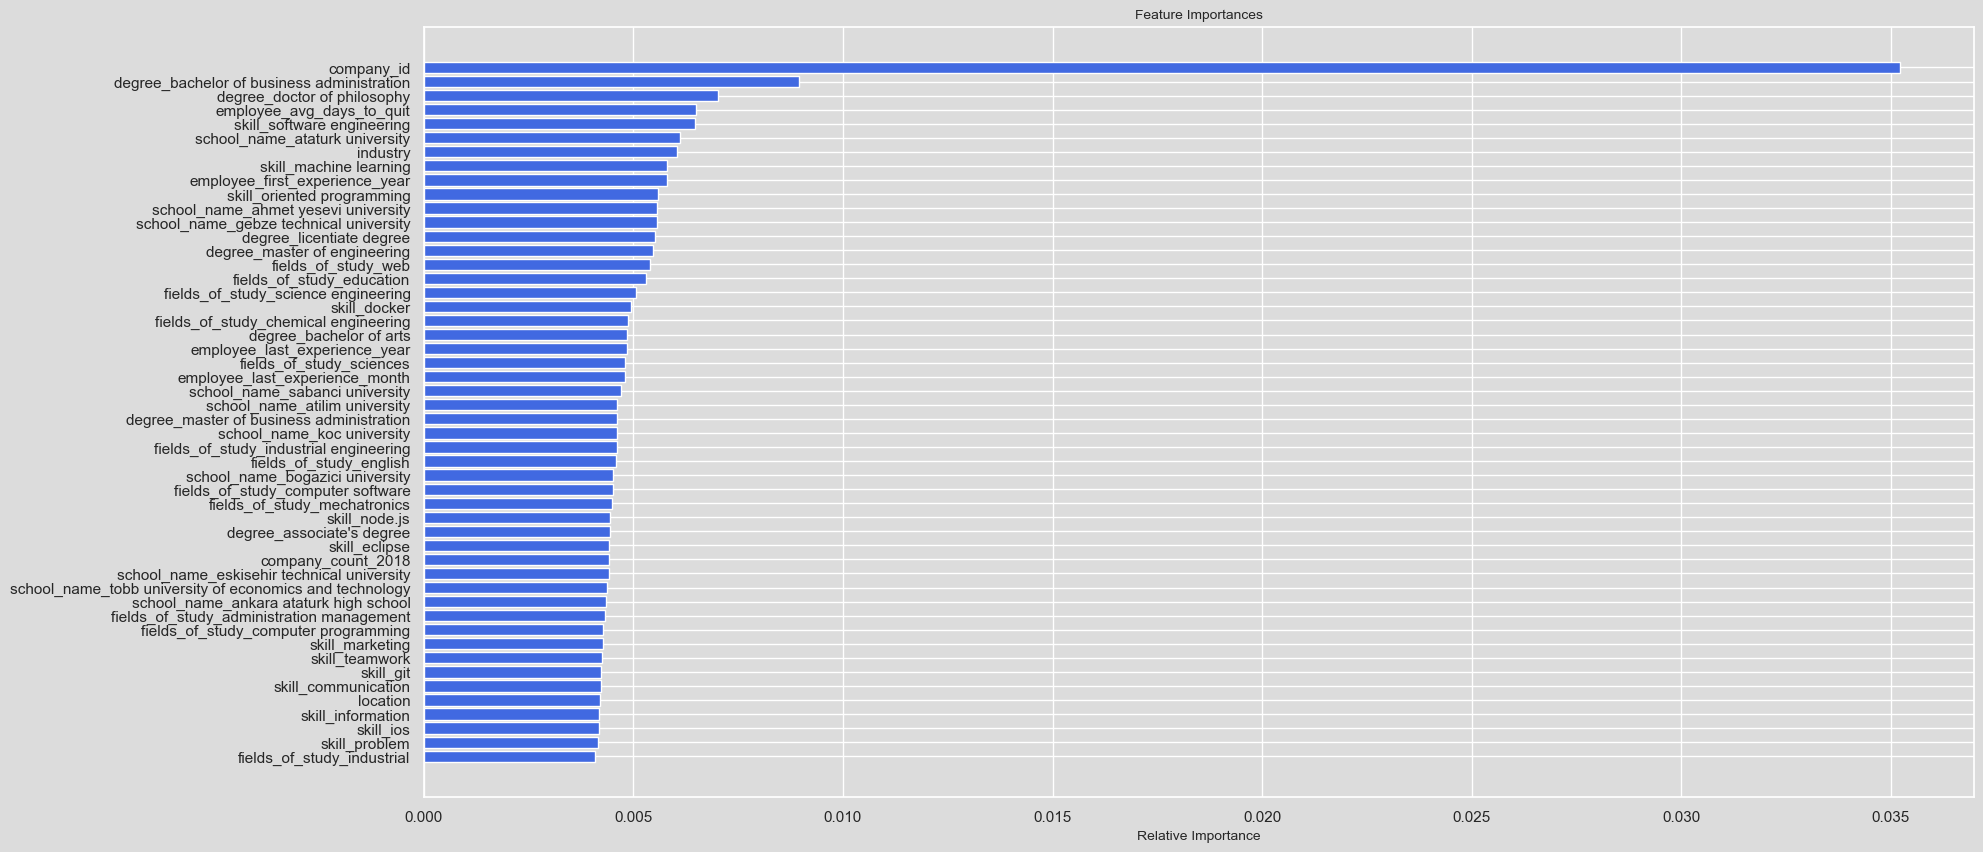

fold accuracy: 0.7854475500735544
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 289)
val: (8836, 289)
[0]	validation_0-logloss:0.69069
[250]	validation_0-logloss:0.53593
[500]	validation_0-logloss:0.50596
[750]	validation_0-logloss:0.48601
[1000]	validation_0-logloss:0.47208
[1250]	validation_0-logloss:0.46196
[1500]	validation_0-logloss:0.45523
[1750]	validation_0-logloss:0.45102
[2000]	validation_0-logloss:0.44865
[2250]	validation_0-logloss:0.44716
[2500]	validation_0-logloss:0.44654
[2750]	validation_0-logloss:0.44706
[3000]	validation_0-logloss:0.44813
[3073]	validation_0-logloss:0.44863


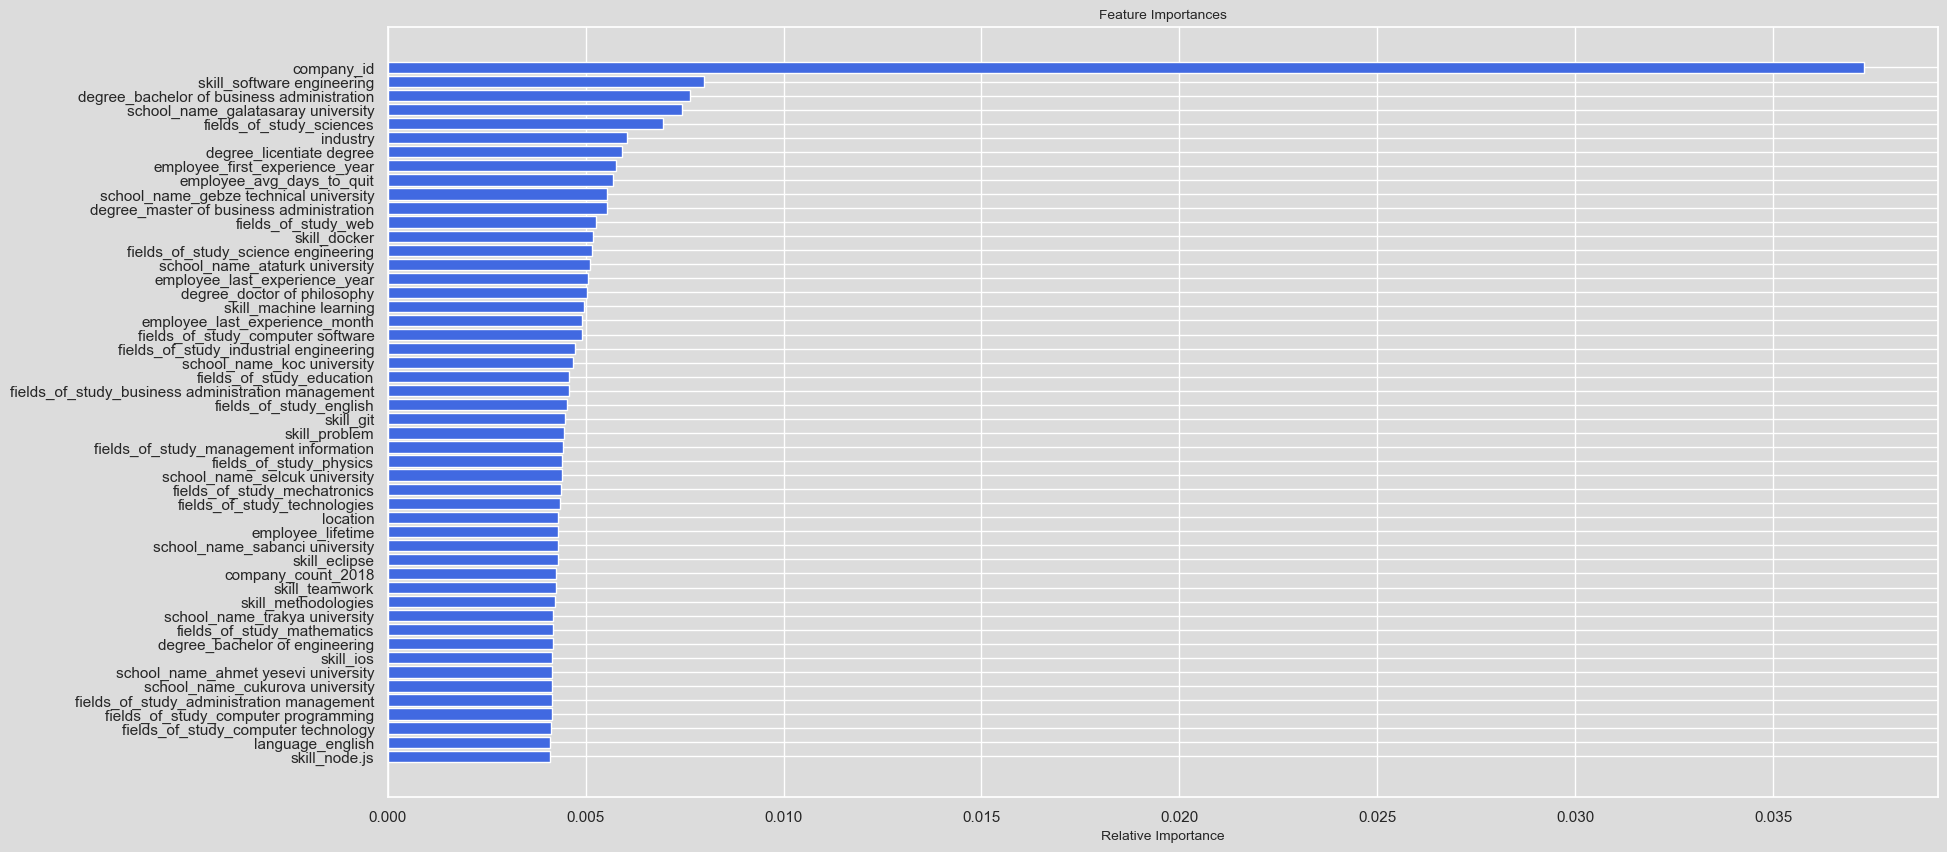

fold accuracy: 0.7881394296061567
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 289)
val: (8836, 289)
[0]	validation_0-logloss:0.69071
[250]	validation_0-logloss:0.53739
[500]	validation_0-logloss:0.50754
[750]	validation_0-logloss:0.48670
[1000]	validation_0-logloss:0.47171
[1250]	validation_0-logloss:0.46123
[1500]	validation_0-logloss:0.45359
[1750]	validation_0-logloss:0.44830
[2000]	validation_0-logloss:0.44548
[2250]	validation_0-logloss:0.44403
[2500]	validation_0-logloss:0.44376
[2750]	validation_0-logloss:0.44417
[3000]	validation_0-logloss:0.44489
[3027]	validation_0-logloss:0.44503


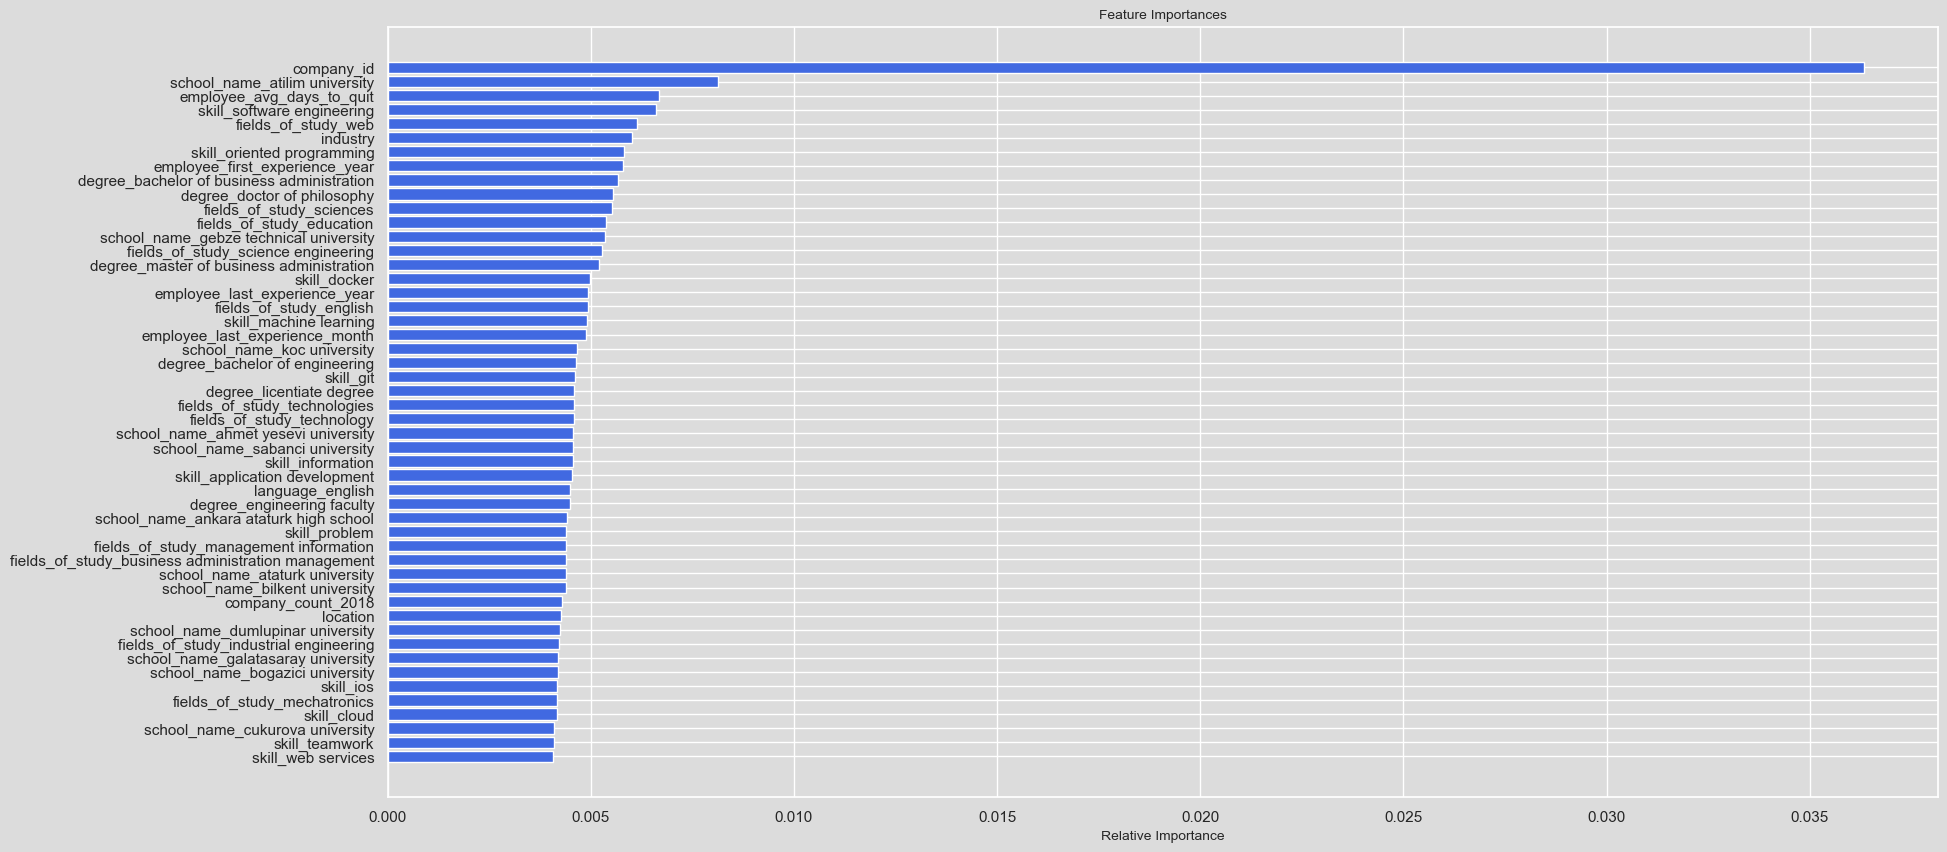

fold accuracy: 0.7866681756450883
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 289)
val: (8836, 289)
[0]	validation_0-logloss:0.69066
[250]	validation_0-logloss:0.53591
[500]	validation_0-logloss:0.50455
[750]	validation_0-logloss:0.48438
[1000]	validation_0-logloss:0.46897
[1250]	validation_0-logloss:0.45793
[1500]	validation_0-logloss:0.45068
[1750]	validation_0-logloss:0.44583
[2000]	validation_0-logloss:0.44300
[2250]	validation_0-logloss:0.44145
[2500]	validation_0-logloss:0.44096
[2750]	validation_0-logloss:0.44157
[2973]	validation_0-logloss:0.44238


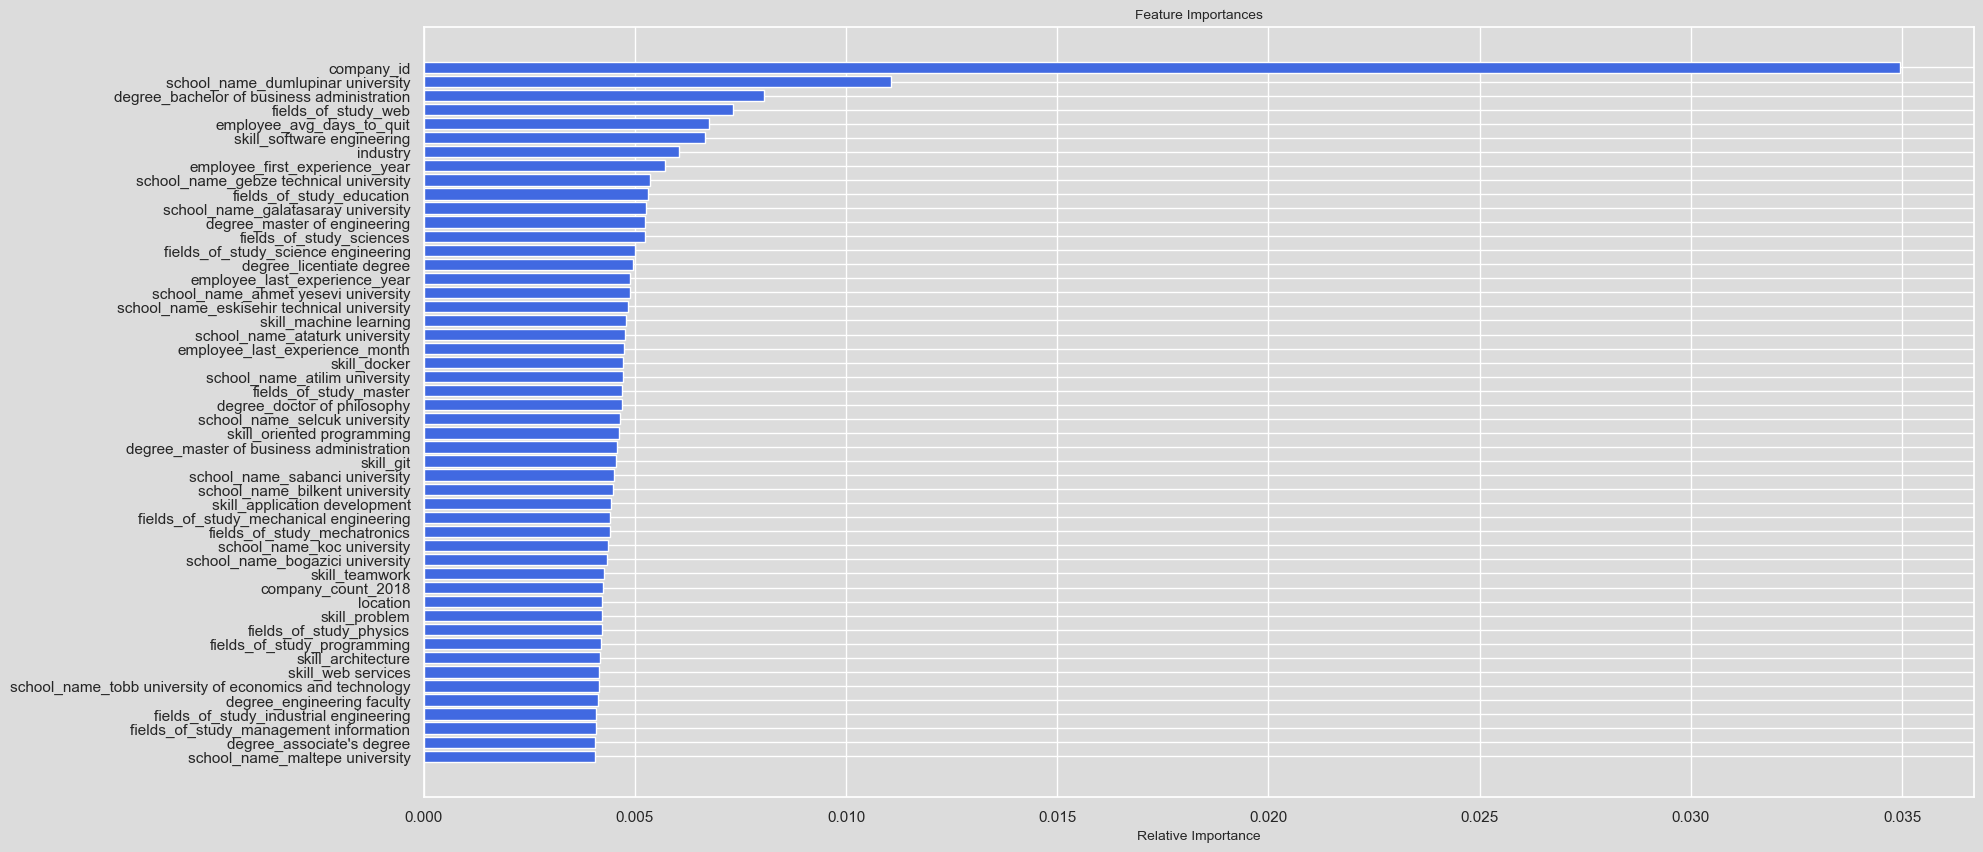

fold accuracy: 0.7871208691715709
accuracy: 0.7863030234444256
folds avg accuracy: 0.786303080390676


In [22]:
xgb1_scores, xgb1_train_scores = get_model_scores(xgb1, skf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #accuracy: 0.7895094211509082

accuracy: 0.7904336181368943 <br>
folds avg accuracy: 0.7904335839357636

-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 289)
val: (8837, 289)
0:	learn: 0.6582092	test: 0.6443363	best: 0.6443363 (0)	total: 302ms	remaining: 20m 6s
250:	learn: 0.8205378	test: 0.7382596	best: 0.7388254 (247)	total: 52.6s	remaining: 13m 5s
500:	learn: 0.8669368	test: 0.7507073	best: 0.7507073 (478)	total: 1m 45s	remaining: 12m 17s
750:	learn: 0.9116156	test: 0.7663234	best: 0.7663234 (749)	total: 2m 38s	remaining: 11m 27s
1000:	learn: 0.9396361	test: 0.7719814	best: 0.7725472 (999)	total: 3m 32s	remaining: 10m 37s
1250:	learn: 0.9584446	test: 0.7796764	best: 0.7796764 (1250)	total: 4m 26s	remaining: 9m 46s
1500:	learn: 0.9708931	test: 0.7808080	best: 0.7823922 (1450)	total: 5m 20s	remaining: 8m 53s
1750:	learn: 0.9791318	test: 0.7826185	best: 0.7830712 (1732)	total: 6m 14s	remaining: 8m
2000:	learn: 0.9839754	test: 0.7854476	best: 0.7857870 (1906)	total: 7m 7s	remaining: 7m 7s
2250:	learn: 0.9879815	test: 0.7871450	best: 0.7877108

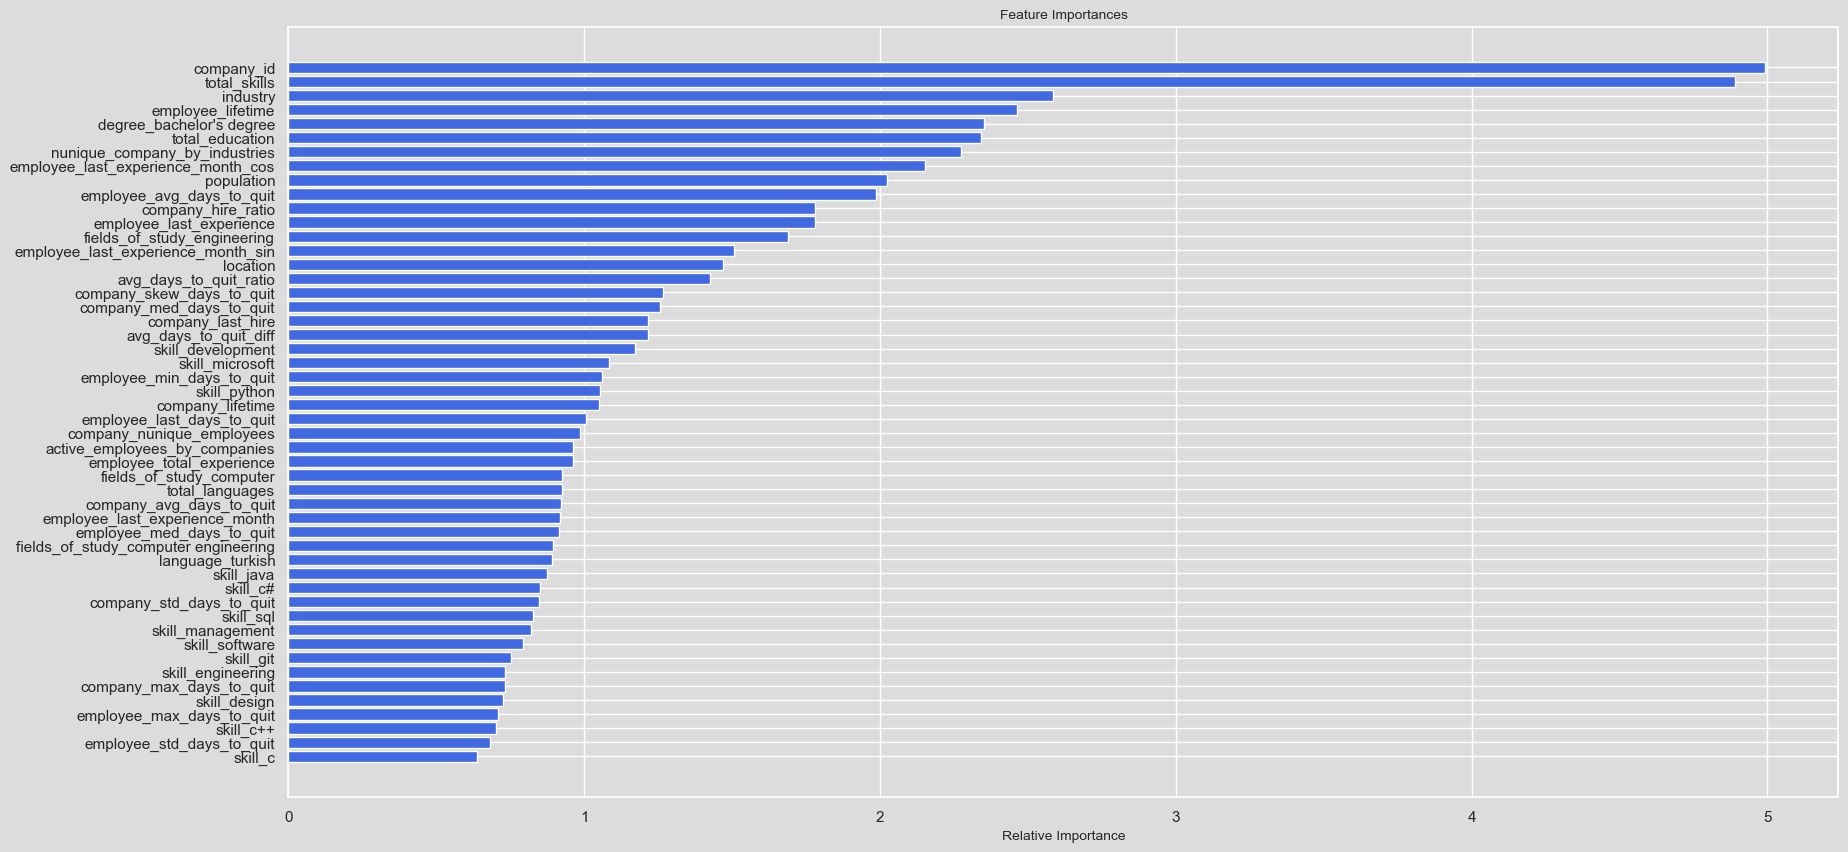

fold accuracy: 0.7881634038700917
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 289)
val: (8837, 289)
0:	learn: 0.6487484	test: 0.6333597	best: 0.6333597 (0)	total: 242ms	remaining: 16m 7s
250:	learn: 0.8163053	test: 0.7430123	best: 0.7433518 (248)	total: 55.6s	remaining: 13m 49s
500:	learn: 0.8650808	test: 0.7591943	best: 0.7596469 (489)	total: 1m 54s	remaining: 13m 21s
750:	learn: 0.9104160	test: 0.7683603	best: 0.7688129 (734)	total: 2m 51s	remaining: 12m 21s
1000:	learn: 0.9394776	test: 0.7749236	best: 0.7750368 (999)	total: 3m 46s	remaining: 11m 17s
1250:	learn: 0.9577882	test: 0.7800158	best: 0.7806948 (1212)	total: 4m 40s	remaining: 10m 16s
1500:	learn: 0.9701009	test: 0.7814869	best: 0.7823922 (1444)	total: 5m 34s	remaining: 9m 17s
1750:	learn: 0.9778869	test: 0.7827317	best: 0.7843159 (1717)	total: 6m 28s	remaining: 8m 19s
2000:	learn: 0.9835680	test: 0.7835238	best: 0.7851081 (1834)	total: 7m 22s	remaining: 7m 22s
2250:	learn:

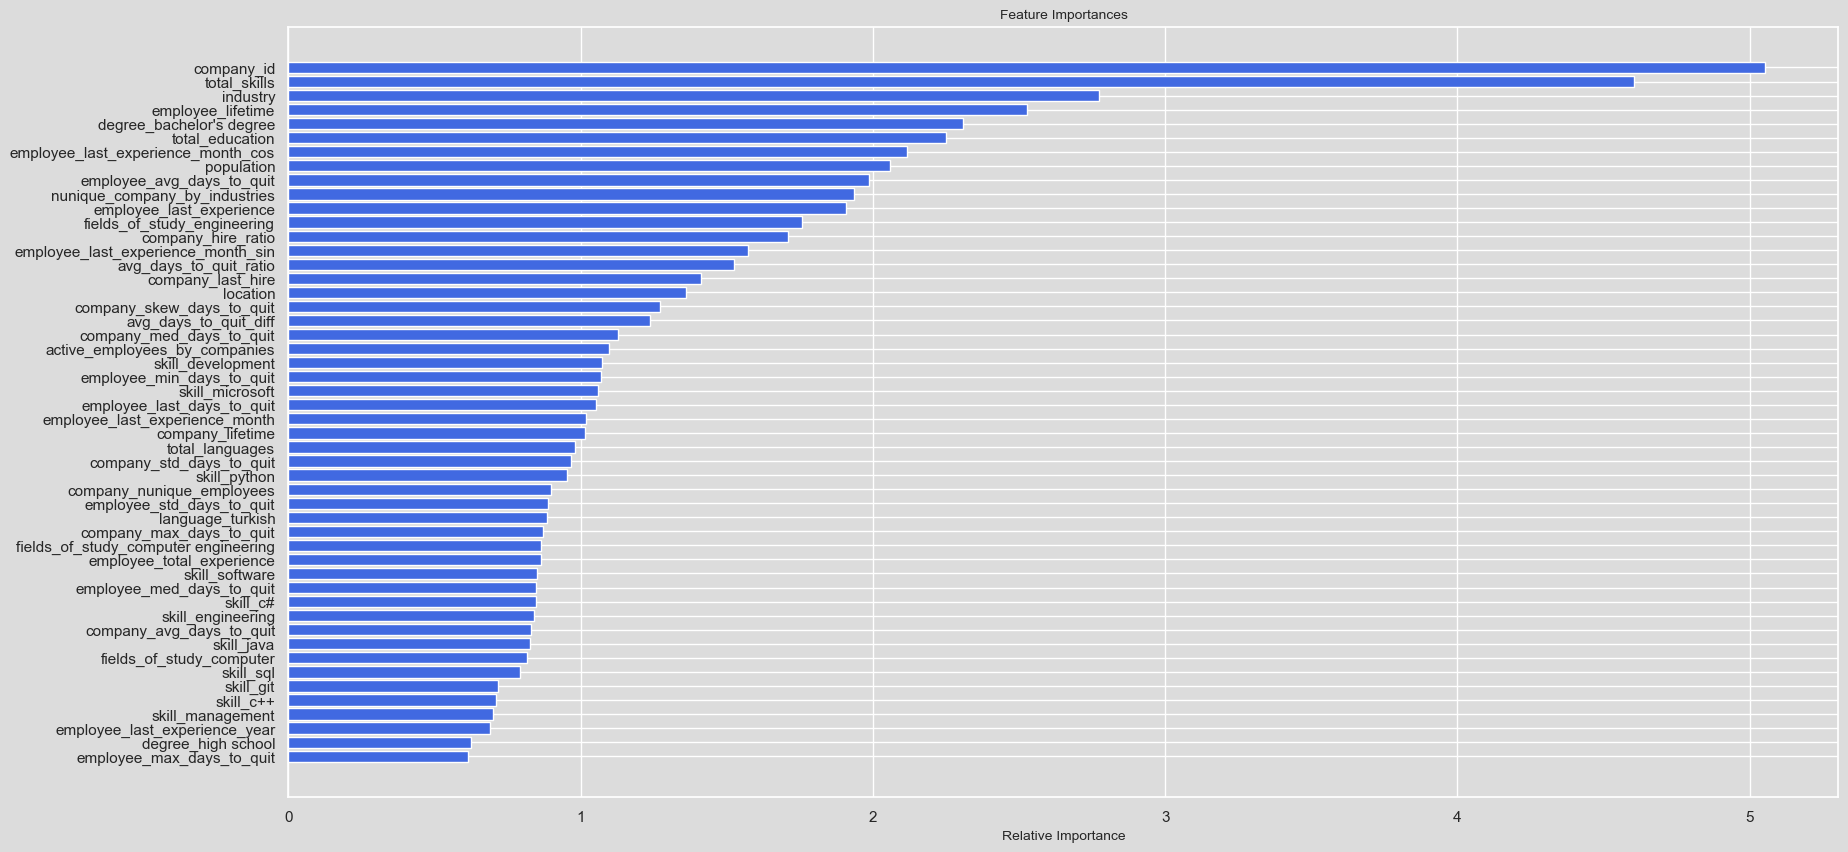

fold accuracy: 0.7851080683489872
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 289)
val: (8837, 289)
0:	learn: 0.6479562	test: 0.6382256	best: 0.6382256 (0)	total: 344ms	remaining: 22m 53s
250:	learn: 0.8196777	test: 0.7444834	best: 0.7448229 (248)	total: 51.7s	remaining: 12m 52s
500:	learn: 0.8678195	test: 0.7610049	best: 0.7615707 (496)	total: 1m 43s	remaining: 12m 5s
750:	learn: 0.9094880	test: 0.7667761	best: 0.7675682 (738)	total: 2m 35s	remaining: 11m 14s
1000:	learn: 0.9369426	test: 0.7729999	best: 0.7739052 (928)	total: 3m 27s	remaining: 10m 23s
1250:	learn: 0.9551854	test: 0.7792237	best: 0.7794500 (1220)	total: 4m 20s	remaining: 9m 31s
1500:	learn: 0.9670001	test: 0.7818264	best: 0.7818264 (1500)	total: 5m 12s	remaining: 8m 39s
1750:	learn: 0.9768231	test: 0.7836370	best: 0.7843159 (1730)	total: 6m 4s	remaining: 7m 48s
2000:	learn: 0.9822779	test: 0.7840896	best: 0.7848817 (1960)	total: 6m 57s	remaining: 6m 56s
2250:	learn: 0

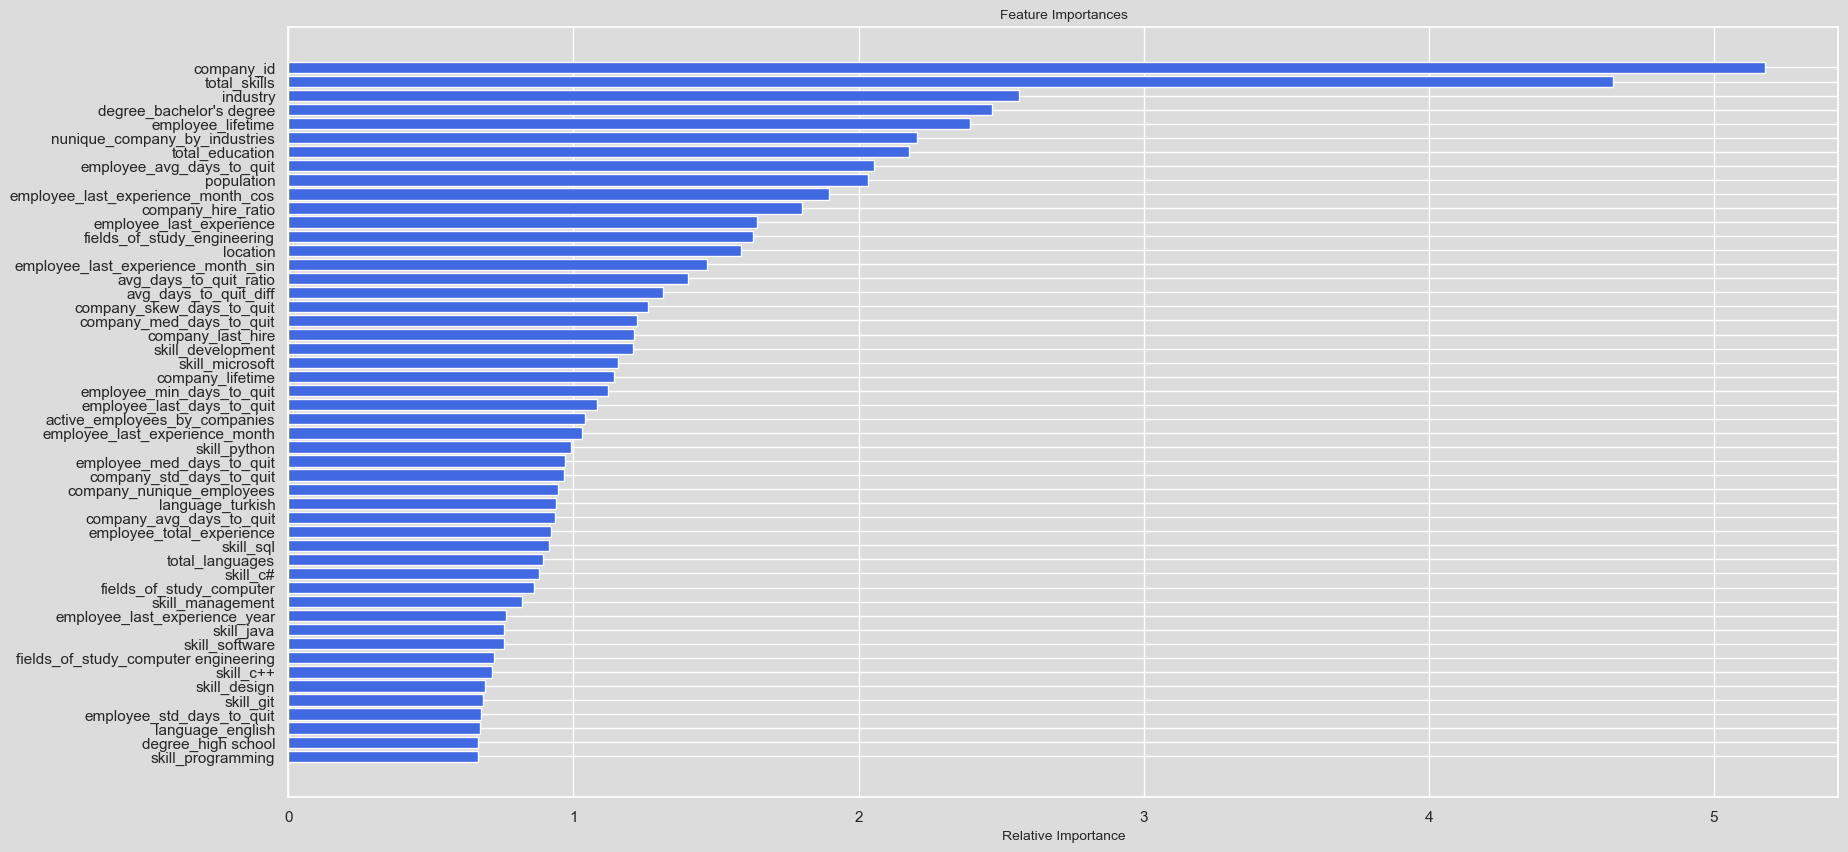

fold accuracy: 0.7861265135226887
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 289)
val: (8836, 289)
0:	learn: 0.6741507	test: 0.6462200	best: 0.6462200 (0)	total: 327ms	remaining: 21m 48s
250:	learn: 0.8179164	test: 0.7463785	best: 0.7466048 (217)	total: 53.6s	remaining: 13m 20s
500:	learn: 0.8701537	test: 0.7616569	best: 0.7622227 (496)	total: 1m 47s	remaining: 12m 27s
750:	learn: 0.9098748	test: 0.7693526	best: 0.7699185 (716)	total: 2m 41s	remaining: 11m 39s
1000:	learn: 0.9370799	test: 0.7764826	best: 0.7764826 (999)	total: 3m 36s	remaining: 10m 47s
1250:	learn: 0.9555938	test: 0.7796514	best: 0.7801041 (1235)	total: 4m 31s	remaining: 9m 55s
1500:	learn: 0.9684268	test: 0.7840652	best: 0.7842915 (1497)	total: 5m 25s	remaining: 9m 1s
1750:	learn: 0.9767558	test: 0.7870077	best: 0.7874604 (1742)	total: 6m 19s	remaining: 8m 7s
2000:	learn: 0.9826856	test: 0.7873472	best: 0.7887053 (1963)	total: 7m 13s	remaining: 7m 12s
2250:	learn: 0

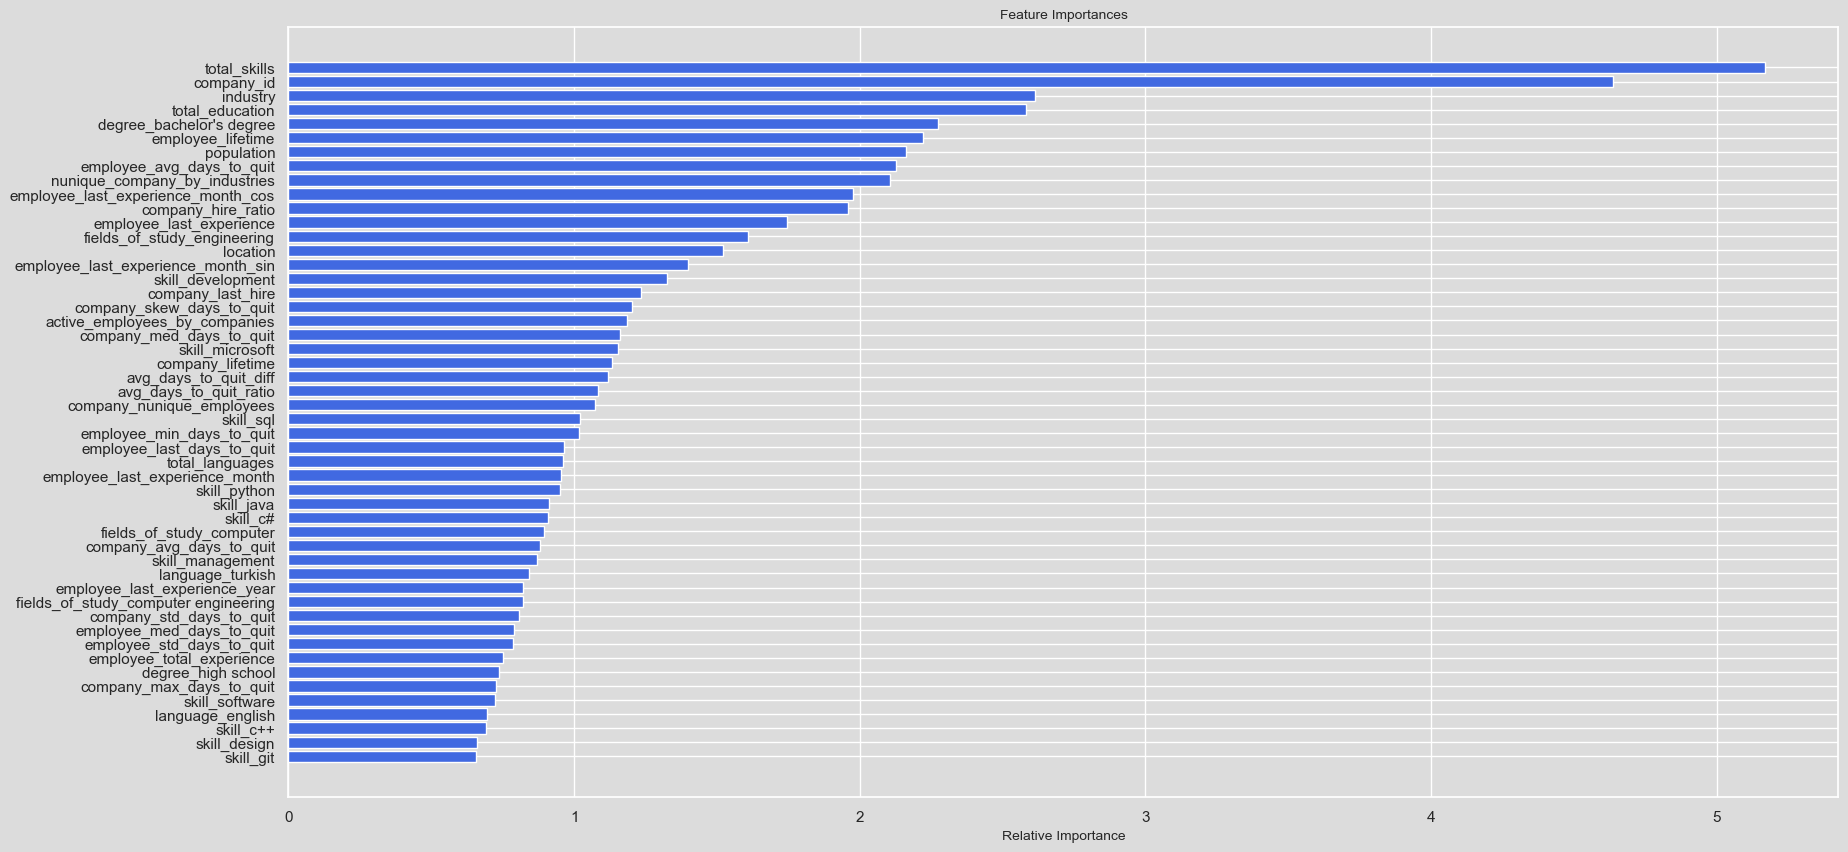

fold accuracy: 0.7905160706201901
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 289)
val: (8836, 289)
0:	learn: 0.6671344	test: 0.6472386	best: 0.6472386 (0)	total: 359ms	remaining: 23m 53s
250:	learn: 0.8129371	test: 0.7445677	best: 0.7450204 (248)	total: 55.8s	remaining: 13m 53s
500:	learn: 0.8618699	test: 0.7564509	best: 0.7570167 (491)	total: 1m 50s	remaining: 12m 52s
750:	learn: 0.9078379	test: 0.7667497	best: 0.7670892 (746)	total: 2m 45s	remaining: 11m 54s
1000:	learn: 0.9393206	test: 0.7775011	best: 0.7777275 (998)	total: 3m 39s	remaining: 10m 57s
1250:	learn: 0.9577439	test: 0.7825939	best: 0.7832730 (1240)	total: 4m 34s	remaining: 10m 2s
1500:	learn: 0.9698979	test: 0.7848574	best: 0.7849706 (1492)	total: 5m 28s	remaining: 9m 7s
1750:	learn: 0.9773216	test: 0.7857628	best: 0.7868945 (1693)	total: 6m 25s	remaining: 8m 14s
2000:	learn: 0.9827535	test: 0.7874604	best: 0.7874604 (1958)	total: 7m 19s	remaining: 7m 19s
2250:	learn: 

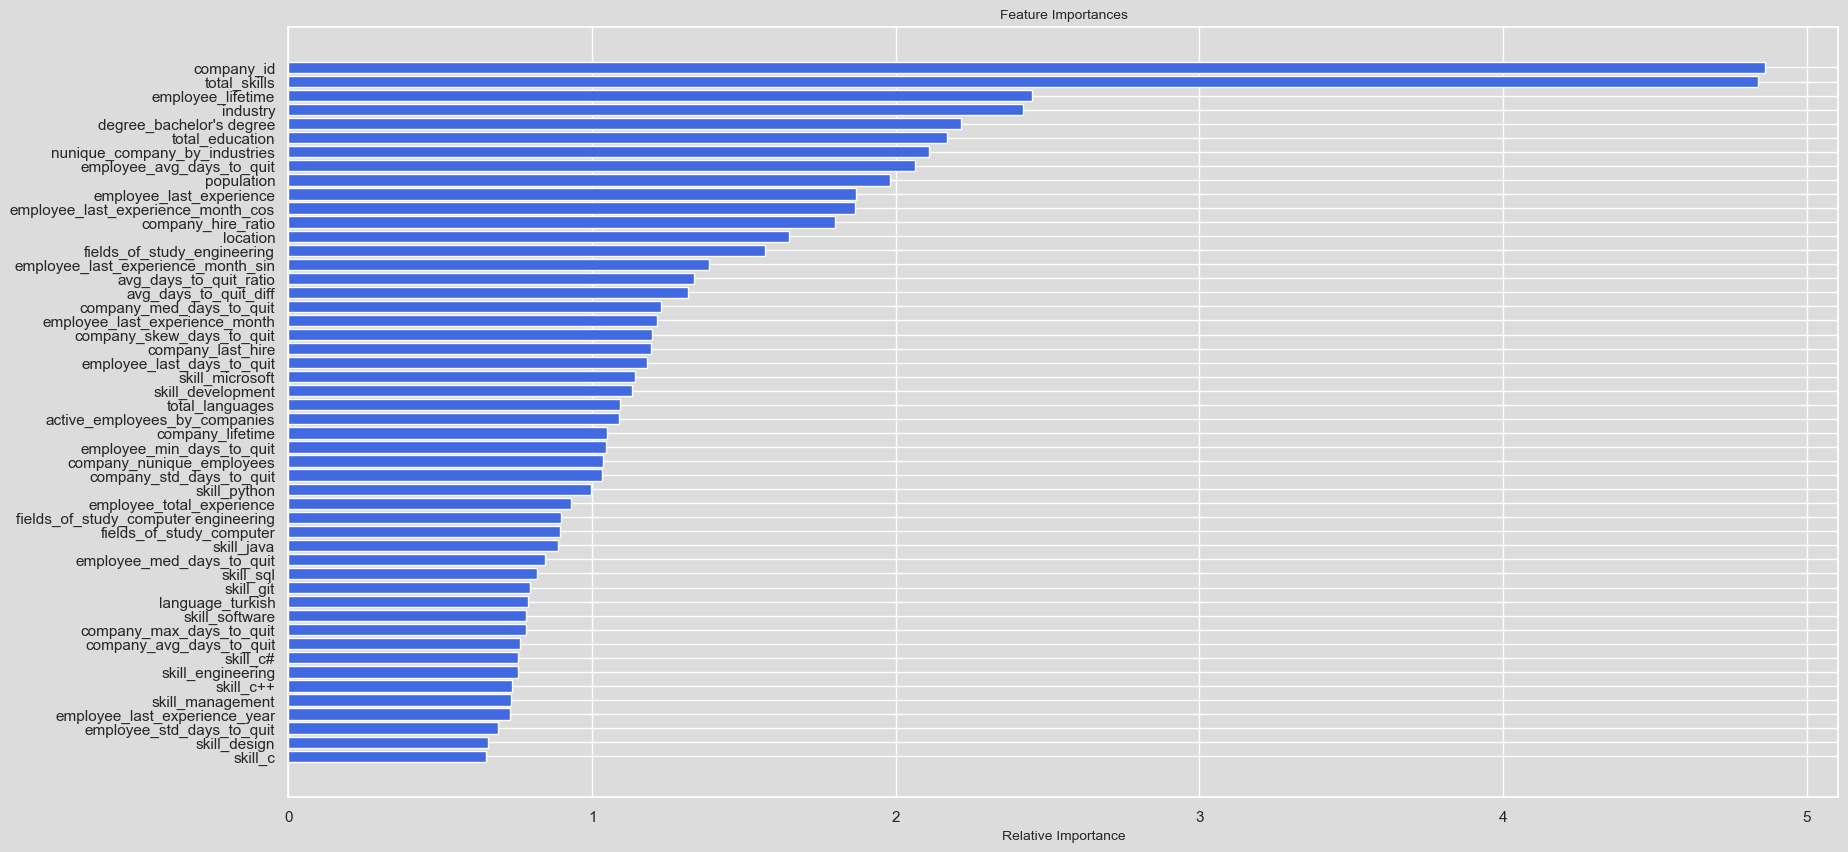

fold accuracy: 0.7882526029877773
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 289)
val: (8836, 289)
0:	learn: 0.6706199	test: 0.6394296	best: 0.6394296 (0)	total: 316ms	remaining: 21m 4s
250:	learn: 0.8164000	test: 0.7451335	best: 0.7452467 (249)	total: 53.3s	remaining: 13m 16s
500:	learn: 0.8646538	test: 0.7581485	best: 0.7586012 (498)	total: 1m 47s	remaining: 12m 30s
750:	learn: 0.9062535	test: 0.7704844	best: 0.7704844 (750)	total: 2m 40s	remaining: 11m 35s
1000:	learn: 0.9351108	test: 0.7759167	best: 0.7765957 (993)	total: 3m 35s	remaining: 10m 46s
1250:	learn: 0.9543716	test: 0.7801041	best: 0.7808963 (1234)	total: 4m 29s	remaining: 9m 53s
1500:	learn: 0.9674083	test: 0.7819149	best: 0.7825939 (1416)	total: 5m 25s	remaining: 9m 1s
1750:	learn: 0.9769821	test: 0.7839520	best: 0.7844047 (1709)	total: 6m 20s	remaining: 8m 8s
2000:	learn: 0.9827988	test: 0.7841784	best: 0.7862155 (1870)	total: 7m 14s	remaining: 7m 14s
2250:	learn: 0.

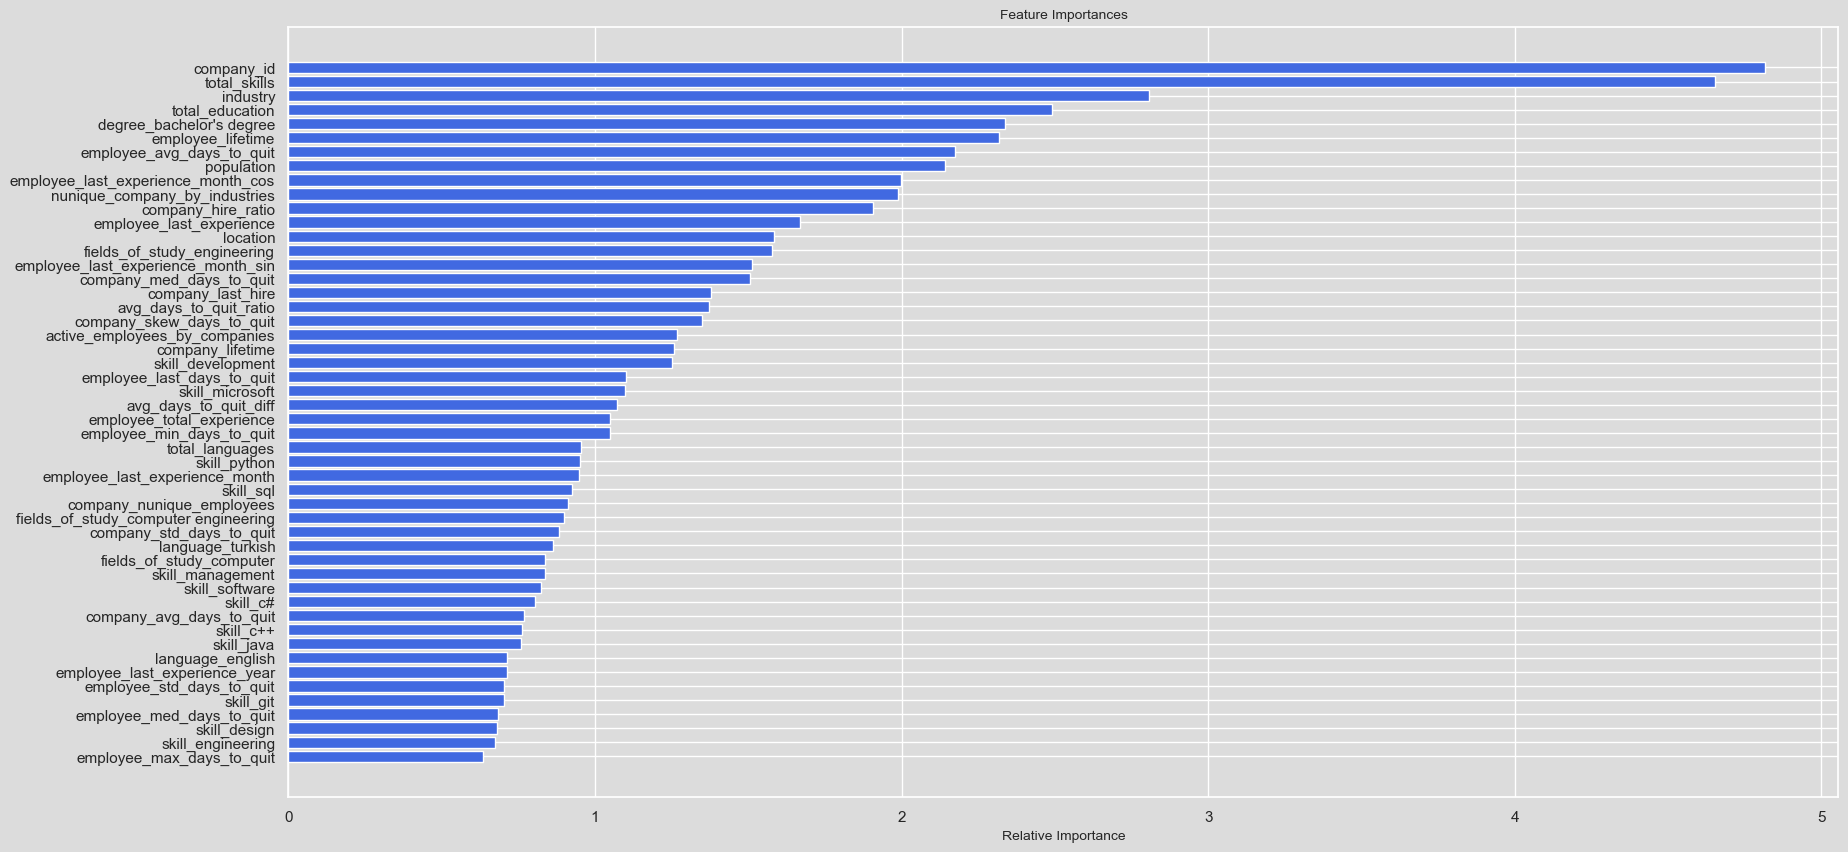

fold accuracy: 0.7867813490267089
accuracy: 0.787491276712122
folds avg accuracy: 0.7874913347294074


In [23]:
cat1_scores, cat1_train_scores = get_model_scores(cat1, skf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #accuracy: 0.7886040853279013

accuracy: 0.7922631509458873 <br>
folds avg accuracy: 0.7922632031969215

In [24]:
thr = 0.499
score_ = list()
w_range = np.arange(0.02, 0.98, 0.02)
for i in w_range:
    score_.append(
        accuracy_score(
            train_set[target],
            np.where(
                cat1_train_scores[:, 1] * i + xgb1_train_scores[:, 1] * (1 - i)
                >= thr,
                1,
                0,
            ),
        )
    )

max_score = np.max(score_)
print(f"max score: {max_score}")
w1 = round(w_range[np.argmax(score_)], 2)
w2 = round(1-w1, 2)
print(f"weight w highest accuracy: {w1} - {w2}")

max score: 0.7897357551066598
weight w highest accuracy: 0.64 - 0.36


In [28]:
sub[target] = np.where((cat1_scores[:, 1] * w1) + (xgb1_scores[:, 1] * w2)  >= thr, 1, 0)

print(sub[target].value_counts())

sub.head(10)

0    9110
1    4145
Name: moved_after_2019, dtype: int64


,user_id,moved_after_2019
0,17449,0
1,33967,0
2,2110,0
3,55082,0
4,37165,0
5,42841,1
6,8407,0
7,17053,0
8,24437,1
9,44394,0


In [26]:
sub.to_csv(f'../submissions/ensemble_cat_xgb_{round(max_score, 6)}.csv', index = False)

In [27]:
#cat1_v2 = CatBoostClassifier(
#    **{
#        "one_hot_max_size": 150,
#        "depth": 12,
#        'learning_rate': 0.02,
#        "boosting_type": "Plain",
#        "bootstrap_type": "MVS",
#        "iterations": 4000,
#        "random_state": config.seed,
#        "cat_features": cat_features,
#        "eval_metric": "Accuracy",
#        "allow_writing_files": False,
#        "verbose": False,
#    }
#)
#
#cat2 = CatBoostClassifier(
#    **{
#        "one_hot_max_size": 180,
#        "depth": 12,
#        'learning_rate': 0.02,
#        "boosting_type": "Plain",
#        "bootstrap_type": "Bernoulli",
#        'subsample': 0.85,
#        "iterations": 5000,
#        "random_state": config.seed,
#        "cat_features": cat_features,
#        "eval_metric": "Accuracy",
#        "allow_writing_files": False,
#        "verbose": False,
#    }
#)
#
#xgb1 = XGBClassifier(
#    **{
#        "max_depth": 12,
#        'subsample': 0.84,
#        'learning_rate': 0.012,
#        #"max_cat_to_onehot": 170,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
##optuna accuracy: 0.7913200717625333
#xgb2 = XGBClassifier(
#    **{
#        'max_depth': 10,
#        'colsample_bylevel': 0.5278208423543558,
#        'learning_rate': 0.013365198710298768,
#        'subsample': 0.8970592179744503,
#        'tree_method': 'hist',
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'n_estimators': 5000,
#        'objective': 'binary:logistic'
#    }
#)
#
#xgb2 = XGBClassifier(
#    **{
#        'max_depth': 8,
#        'colsample_bytree': 0.9022539835244943,
#        'learning_rate': 0.029665791085370145,
#        'subsample': 0.10503841501004575,
#        'tree_method': 'hist',
#        'enable_categorical': True,
#        'random_state': 42,
#        'n_estimators': 5000,
#        'objective': 'binary:logistic',
#        'gamma': 2.846243837248615e-05
#    }
#)
#
#xgb1_v2 = XGBClassifier(
#    **{
#        "max_depth": 12,
#        'subsample': 0.84,
#        'learning_rate': 0.012,
#        #"max_cat_to_onehot": 170,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
#xgb4 = XGBClassifier(
#    **{
#        "max_depth": 13,
#        'subsample': 0.88,
#        'learning_rate': 0.018,
#        'colsample_bylevel': 0.72,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
##optuna accuracy: 0.791263431000755
#xgb7 = XGBClassifier(
#    **{
#        'max_depth': 13,
#        'colsample_bylevel': 0.5015371836125226,
#        'learning_rate': 0.01378678089792197,
#        'subsample': 0.8887196385241469,
#        'tree_method': 'hist',
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'n_estimators': 5000,
#        'objective': 'binary:logistic'
#    }
#)